## Intro and summary of script

When PMF finalists access the Talent Management System (TMS), they eventually reach a webpage with a table of every currently open position. Each row doubles as a javascript button, which when clicked brings the finalist to a page with the full description of that particular job.

Using a web browsers 'inspect element' function, you can quickly see a pattern in those buttons. Each is uniquely named after the opportunity number (eg 217 for posting PMF-2017-0217). Because of that pattern, a webscraper can easily be written to 'click' each button in turn. Once a button is clicked, the HTML from the page with the detailed description may then be scraped for local storage.

This notebook has 2 basic parts. The first part uses the webscraper Selenium to gather PMF position information for local storage. The script is not purely automated. When Selenium initially opens the url, the user must log into the TMS, navigate to the page with the table listing every opportunity, and set the page to display all available jobs. Additionally, a table of the available jobs to be saved as an excel file before running the scraping portion of the script.

During scraping the HTMl content of each individual job posting is saved in a Pandas dataframe. Afterwards, some clunky code pulls out useful bits of information (job title, location, closing date, etc) into different columns in the dataframe before saving the dataframe as a CSV file locally.

The 2nd part of this notebook opens that locally saved CSV file and does some additional processing. Most importantly, it breaks up each posting by locations. For example, if an opportunity has 3 available positions in DC and 1 available position in CO, this section of the script breaks those into 2 different rows. A bit of additional code does a boolean test for the possible starting grade level.

As this is a Python notebook, I will be standing on the shoulders of giants by using clever packages and modules others have built. I import them here.

In [1]:
from selenium import webdriver #selenium is used to interact with the webpage, so the program can 'click' buttons.
#also make sure to have the application geckodriver in system path. Selenium needs this to function.
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary #This will let the program open the webpage on a new Firefox window.
import sys #This is only used to assign a location to my path. The location of the application geckodriver.
from bs4 import BeautifulSoup #BeautifulSoup is used to parse the HTML of the downloaded website to find the particular information desired.
import time #I will need to delay the program to give the webpage time to open. time will be used for that.
import pandas as pd #the data will be saved locally as a csv file. Pandas is a nice way to write/read/work with those files.
import numpy as np #to do math
import matplotlib.pyplot as plt #To make plots
import seaborn as sns #To make plots in a different way
%matplotlib inline

## Part 1: Scraping the data

This script uses the selenium package to interact with javascript buttons in an opened firefox browser window. Something that is not always obvious in the selenium docs is that a secondary application, geckodriver, needs to be in the system path to have selenium work properly. This first little bit of code just makes sure that the location of geckodriver is in the path.

In [2]:
sys.path
sys.path.append('C:\\Users...\\folder_with_geckodriver')
#If this fails, try putting geckodriver in same working folder as notebook.

Now I can have Selenium open a Firefox browser using the url of the PMF TMS listings.

In [3]:
url='https://apply.pmf.gov/opportunity_search_results.aspx'
binary = FirefoxBinary('C:\\Program Files (x86)\\Mozilla Firefox\\firefox.exe')
driver = webdriver.Firefox(firefox_binary=binary)
driver.get(url)

If everying is behaving correctly, a new Firefox browser window should have opened at the log in page for the TMS. Before continuing script, go to that browser window, log in, navigate to the table of listings, and set up the table to display all open postings.

Next, do a quick copy/paste of all the available listings into an excel doc (listingsXXXXXX, X...X==date), then let the web scraper use that as a reference for gathering the individual job data. Sure you could scrape this information from the page, but the added code isn't worth the little bit of time it takes to copy/paste a single table.

In [4]:
df_listings=pd.read_excel("listingsXXXXXX.xlsx")
print(len(df_listings))
df_listings.head(3)

91


,Agency/Sub-Agency,Position Title,Announcement Number,Series/Grade,Opening Date,Closing Date
0,Broadcasting Board of Governors,Research Analyst,PMF-2017-0003,343,2017-01-13,2017-12-13
1,Department of the Treasury / Departmental Offices,Policy Advisor,PMF-2017-0034,301,2017-02-16,2017-03-16
2,Department of the Interior,Arctic Invasive Alien Species Coordinator/Prog...,PMF-2017-0045,343,2017-02-13,2017-12-31


Verify that the length of df_listings == # of available positions.

Now the code will pull the unique number for each job posting and save it in a list. These numbers should look like the numbers that identifies each javascript button. We will use a fow loop to step through this list, letting selenium 'click' the button corresponding to each number in turn.

In [5]:
ind_listings=df_listings.loc[:,'Announcement Number'].str[-4:].values

The next step is to initialize a pandas dataframe with that information. This dataframe will be where the HTMl of each posting's individual webpage is also saved.

In [6]:
df=pd.DataFrame()
df['listing']=ind_listings
df['info']='1'

Finally, it's time to let this script interact with the TMS. The next block scrapes the data, jumping back and forth between the listings and individual job postings, and with some delay built in to let the browser finish opening a new page before the script continues. You can watch the Firefox browser window while this is happening, which can be very satisfying.

In [7]:
for elm in df.loc[:,'listing']:
    #below: each javascript button associated with every row of the TMS is named after the job number
    #This for loop 'clicks' on each button in turn by making use of that pattern.
    driver.find_element_by_xpath('//a[@href="javascript:goSubmit(%s);"]'%(int(elm))).click()
    time.sleep(1) #delay to let the page load
    html = driver.page_source #downloading html of individual job description
    soup = BeautifulSoup(html,'lxml') #decoding the html into a workable form.
    data=soup.find('main') #side stepping all the CSS information from the webpage
    test=[]
    #below: this little loop finds the job description part of the main HTML section and
    #saves it as a string in df
    for row in data:
        if 'Announcement Number' in str(row):
            test.append(row)
    df.loc[df.loc[:,'listing']==elm,'info']=str(test[0])
    driver.find_element_by_xpath('//button[text()="Back"]').click() #return to TMS table and prepare to repeat.
    time.sleep(1) #delay to let the page load

Now all the data is locally captured, although not very easy to read:

In [8]:
df.tail()

,listing,info
86,0314,"<div class=""row"">\n<div class=""col-sm-10"">\n<d..."
87,0315,"<div class=""row"">\n<div class=""col-sm-10"">\n<d..."
88,0316,"<div class=""row"">\n<div class=""col-sm-10"">\n<d..."
89,0317,"<div class=""row"">\n<div class=""col-sm-10"">\n<d..."
90,0318,"<div class=""row"">\n<div class=""col-sm-10"">\n<d..."


Verify that there are the correct number of rows.

In [9]:
len(df)

91

A bit of clunky code pulls out some of the standard information into new columns for easier analysis.

In [10]:
#test=pd.DataFrame();
#test['label']=range(0,10)
for x in range(0,len(df)):
    a=BeautifulSoup(df.loc[x,'info'], "html.parser")
    b=a.text.split('\n')
    df.loc[x,'Position Title']=b[b.index('Position Title')+1]
    df.loc[x,'Agency/Sub-Agency']=b[b.index('Agency/Sub-Agency')+1]
    df.loc[x,'Opening Date']=b[b.index('Opening Date')+1]
    df.loc[x,'Closing Date']=b[b.index('Closing Date')+1]
    df.loc[x,'Positions']=b[b.index('Number of Positions and Location(s)')+1:b.index('Job Series and Occupational Group')]
    df.loc[x,'Series']=b[b.index('Job Series and Occupational Group')+1]
    df.loc[x,'Grade Level']=b[b.index('Pay Plan, Grade Level, and Salary Range')+1:b.index('Promotion Potential')]
    df.loc[x,'Promotion Potential']=b[b.index('Promotion Potential')+1]

In [11]:
df.head(3)

,listing,info,Position Title,Agency/Sub-Agency,Opening Date,Closing Date,Positions,Series,Grade Level,Promotion Potential
0,0003,"<div class=""row"">\n<div class=""col-sm-10"">\n<d...",Research Analyst,Broadcasting Board of Governors,1/13/2017,12/13/2017,"[1 in Washington, DC]",0343 - Management And Program Analysis,"[GS-11$66,510 - $86,460]",GS-13
1,0034,"<div class=""row"">\n<div class=""col-sm-10"">\n<d...",Policy Advisor,Department of the Treasury / Departmental Offices,2/16/2017,3/16/2017,"[1 in Washington, DC]",0301 - Miscellaneous Administration And Program,"[GS-11$54,972 - $66,510]",GS-13
2,0045,"<div class=""row"">\n<div class=""col-sm-10"">\n<d...",Arctic Invasive Alien Species Coordinator/Prog...,Department of the Interior,2/13/2017,12/31/2017,"[1 in Washington, DC]",0343 - Management And Program Analysis,"[GS-09, GS-11, GS-12$54,972 - $103,639]",GS-12


Finally, this dataframe is locally saved.

In [12]:
df.to_csv('listingsSnapShotXXXXXX.csv',index=False)

## Part 2: Analyse

A bit of work with the standard information that was saved in unique columns before. First the locally saved information is loaded as a dataframe:

In [13]:
df=pd.read_csv('listingsSnapShotXXXXXX.csv',encoding = "ISO-8859-1")
date='XX/XX/XXXX'

A new dataframe is created with only the standard data. This keeps the original data safe in case of overwriting or other bad events. Not every column is transfered to the new dataframe and some new columns are created. The code is clunky, but it breaks up opportunities with multiple locations and looks for Grade Level information.

In [14]:
df2=pd.DataFrame(columns=['Listing','Position Title', 'Agency/Sub-Agency',
       'Opening Date', 'Closing Date', 'Number of Positions','State', 'Series', 'GS-09','GS-11','GS-12','GS-13',
       'Promotion Potential'])
x=0
y=0
for x in range(0,len(df)):
    subtest1=[]
    subtest2=[]
    z=0
    c=df.loc[x,'Positions'].split();
    for elm in c:
        if elm=='in':
            try:
                subtest1.append(int(c[z-1]))
                #print(int(c[x-1]))
            except:
                subtest1.append(int(c[z-1][2:]))
                subtest2.append(c[z-1][0:2])
        z=z+1
    subtest2.append(c[-1])
    for w in range(0,len(subtest1)):
        df2.loc[y,'Listing']=df.loc[x,'listing']
        df2.loc[y,'Position Title']=df.loc[x,'Position Title']
        df2.loc[y,'Agency/Sub-Agency']=df.loc[x,'Agency/Sub-Agency']
        df2.loc[y,'Opening Date']=df.loc[x,'Opening Date']
        df2.loc[y,'Closing Date']=df.loc[x,'Closing Date']
        df2.loc[y,'Series']=df.loc[x,'Series'][0:4]
        df2.loc[y,'Position Title']=df.loc[x,'Position Title']
        df2.loc[y,'Position Title']=df.loc[x,'Position Title']
        df2.loc[y,'Position Title']=df.loc[x,'Position Title']
        df2.loc[y,'GS-09']= 'GS-09' in df.loc[x,'Grade Level']
        df2.loc[y,'GS-11']= 'GS-11' in df.loc[x,'Grade Level']
        df2.loc[y,'GS-12']='GS-12' in df.loc[x,'Grade Level']
        df2.loc[y,'GS-13']='GS-13' in df.loc[x,'Grade Level']
        df2.loc[y,'Promotion Potential']=df.loc[x,'Promotion Potential']
        df2.loc[y,'Number of Positions']=subtest1[w]
        #df2.loc[y,'State']=subtest2[w]
        df2.loc[y,'State']=subtest2[1][0:2]
        y=y+1

In [25]:
df2.head(3)

,Listing,Position Title,Agency/Sub-Agency,Opening Date,Closing Date,Number of Positions,State,Series,GS-09,GS-11,GS-12,GS-13,Promotion Potential
0,3,Research Analyst,Broadcasting Board of Governors,1/13/2017,12/13/2017,1,DC,0343,False,True,False,False,GS-13
1,34,Policy Advisor,Department of the Treasury / Departmental Offices,2/16/2017,3/16/2017,1,DC,0301,False,True,False,False,GS-13
2,45,Arctic Invasive Alien Species Coordinator/Prog...,Department of the Interior,2/13/2017,12/31/2017,1,DC,0343,True,True,True,False,GS-12


Now some simple analysis may be done. First up, the total number of positions listed.

In [15]:
df2.loc[:,'Number of Positions'].sum()

364

It's possible just a few postings account for many of this positions. A bit of code to check that:

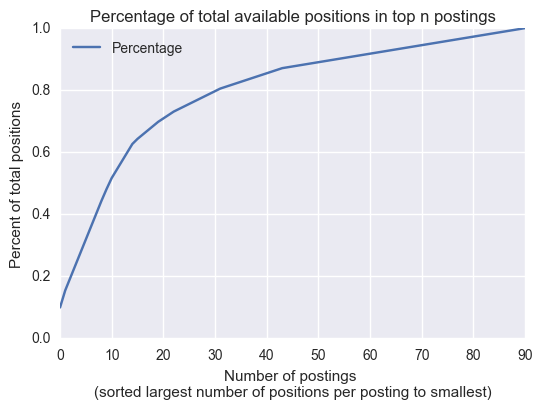

In [18]:
a=list(df2.loc[:,'Listing'].value_counts().index.values)
a.sort()
df_temp=pd.DataFrame();
df_temp['Listing']=a
x=0
for elm in a:
    df_temp.loc[x,'Number of Openings']=df2.loc[df2.loc[:,'Listing']==elm,'Number of Positions'].sum()
    x=x+1
b=df_temp.sort_values('Number of Openings', ascending=False)
b['Percentage']=0
b.reset_index(inplace=True)
del b['index']
for x in range(0,len(b)):
    b.loc[x,'Percentage']=b.loc[0:x,'Number of Openings'].sum()/(df2.loc[:,'Number of Positions'].sum())
b.plot(y='Percentage')
plt.ylabel('Percent of total positions')
plt.xlabel('Number of postings \n(sorted largest number of positions per posting to smallest)')
plt.title('Percentage of total available positions in top n postings');

So in the above example, the top 10 postings have over half the available positions.

Another way to look at the scraped data is to go back to df2 and make countplots of individual columns.

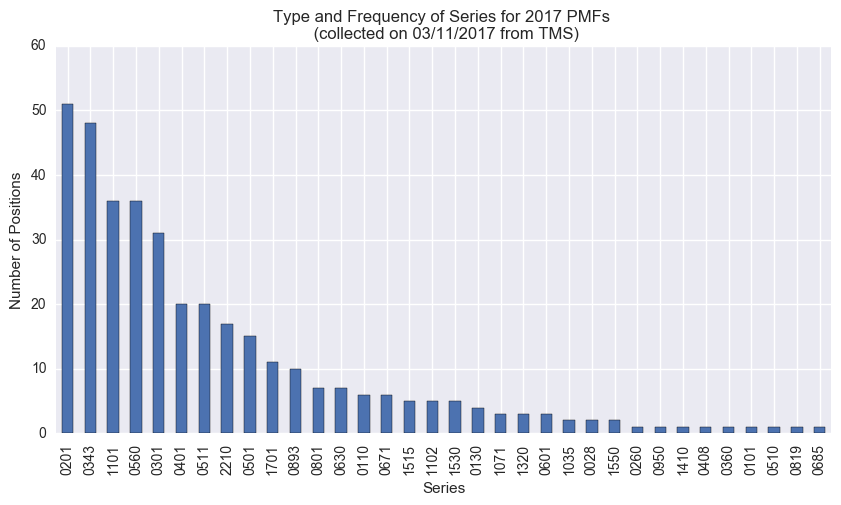

In [19]:
val='Series'
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
#sns.barplot(x=val,y='Count',data=df_titleTypes)
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[10,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs \n (collected on %s from TMS)'%(val,date));

Same code block as above, duplicated here to show how a different column gives a different countplot

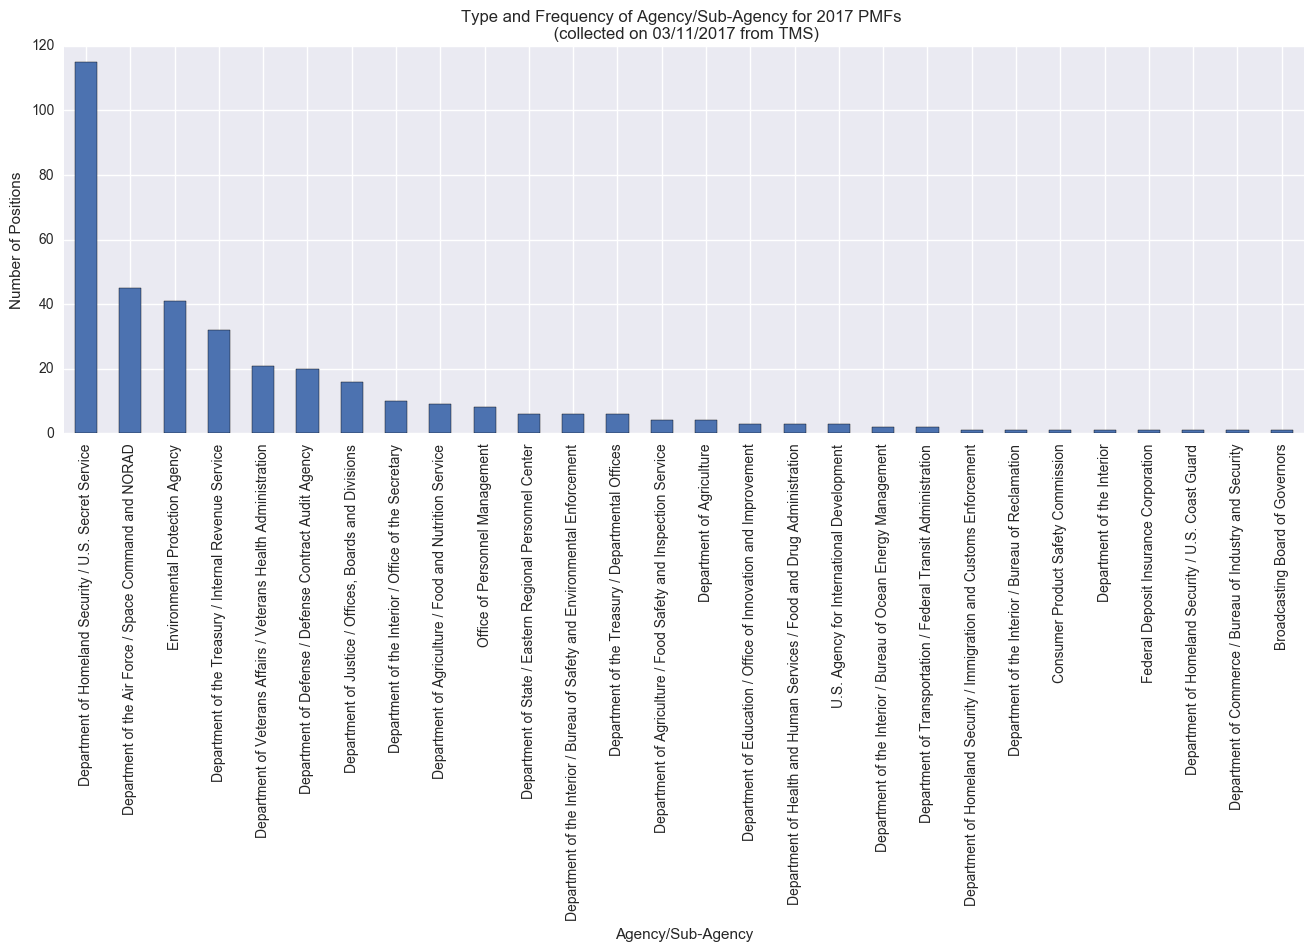

In [20]:
val='Agency/Sub-Agency'
df_titleTypes=pd.DataFrame()
df_titleTypes[val]=df2.loc[:,val].value_counts().index.values
df_titleTypes['Count']=0
for x in range(0,len(df2)):
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']=(
    df_titleTypes.loc[df_titleTypes.loc[:,val]==df2.loc[x,[val]].values[0],'Count']+df2.loc[x,['Number of Positions']].values[0])
df_titleTypes.sort_values(by='Count',ascending=False,inplace=True)
#sns.barplot(x=val,y='Count',data=df_titleTypes)
df_titleTypes.plot(x=val, y='Count', kind='bar',legend=False,figsize=[16,5])
plt.xticks(rotation=90);
plt.ylabel('Number of Positions')
plt.title('Type and Frequency of %s for 2017 PMFs \n (collected on %s from TMS)'%(val,date));

This bit of code shows the distribution of starting grades

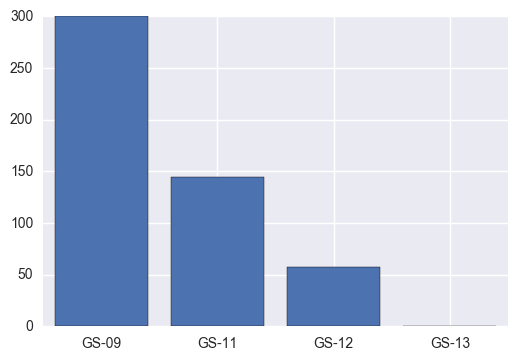

In [21]:
GS09=df2.loc[df2.loc[:,'GS-09'],'Number of Positions'].sum()
GS11=df2.loc[df2.loc[:,'GS-11'],'Number of Positions'].sum()
GS12=df2.loc[df2.loc[:,'GS-12'],'Number of Positions'].sum()
GS13=df2.loc[df2.loc[:,'GS-13'],'Number of Positions'].sum()
LABELS=['GS-09','GS-11','GS-12','GS-13'];
plt.bar([1,2,3,4],[GS09,GS11,GS12,GS13],align='center');
plt.xticks([1,2,3,4], LABELS);

And final grades.

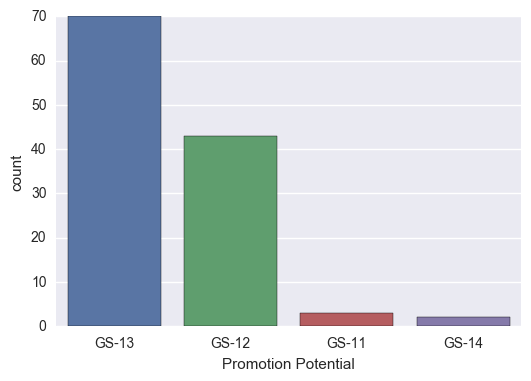

In [22]:
sns.countplot(x=df2['Promotion Potential'])

Further work can be done. For example, mining the individual job descriptions to look for the most common words. Perhaps in the future.